# Example: Azimuthal Integration with FPGA bincount

## Introduction

This notebook is a basic demonstration of AZimuthal INTegration of powder diffraction data with `bincout` both from `numpy` and with FPGA.

In this demo we will:
- define environment
- load some compressed HDF5 data
- integrate data using `numpy.bincount` ... in order to have some reference 
- integrate data on FPGA
- visualize the processed data
- simply analyze peak position in the processed data and demonstrate a presence of phase transition in the demo data

Requirements:
- Intel/Altera FPGA supporting OpenCL (Intel PAC A10, S10, equivalent Bittware board etc.)
- Intel(R) FPGA SDK for OpenCL(TM) 
- numpy, matplotlib, h5py and bitshuffle (providing HDF5 plugin), PyOpenCL, jupyter (and papermill)
- HDF5 $DyCo_2$ dataset: [Dropbox-link](https://www.dropbox.com/s/lh43penrjg9chit/hc2040_DyCo2.h5?dl=0) (*TODO*: publish on Zenodo)
- 70 GB RAM is advised. In order to explore the FPGA performance, it will be needed to keep the image data uncompressed in the host memory. The data loading and decompression process can peak memory usage up to 70 GB. Uncompressed data in memory will be around 45 GB. It is likely possible to run the example also with half of data, i.e. minimum memory requirement is about 32 GB.

In general it should be possible to run this example on [Intel Device Cloud](https://www.intel.com/content/www/us/en/developer/tools/devcloud/fpga/overview.html). Python software is easily available with Conda.

Runtime 5 min (FPGA binary image is expected to be built already, check: [DevCloud tutorial](https://gitlab.com/MAXIV-SCISW/compute-fpgas/bincount/-/blob/main/README.md)).<br>
Reading 20 min.

## Environment

First of all one should be sure we have some well defined environment. Likely not all is necessary and so this cell can also provide some hints for troubleshooting.

**hc2040_DyCo2.h5** (10.5 GB) dataset is needed for a real application example. It can be downaloded from here: [hc2040_DyCo2.h5 on Dropbox](https://www.dropbox.com/s/lh43penrjg9chit/hc2040_DyCo2.h5?dl=0) (*TODO*: publish on Zenodo). It is assumed the downloaded file is in directory defined in the enviromental variable `DATA_DIR`.

FPGA `bincount` will be looking for *OpenGL FPGA runtime* environment and device. It will call `pyopencl.create_some_context` method. A hint can be provided to this method via the enviromental variable `PYOPENCL_CTX`.

Data are compressed with [kiyo-masui/bitshuffle-lz4](https://github.com/kiyo-masui/bitshuffle) HDF5 compression filter. `h5py` library will look for the filter in a path defined by env varaible `HDF5_PLUGIN_PATH`. The filters can be found also in a `plugin` subdirectory of `bitshuffle` module.

The `bitshuffle` compression plugin can be compiled with or without OpenMP support. In case of enabled OpenMP and many-core processor, using very many OpenMP threads simultaneosly may have rather negative effect on decompression performance. A hint about using limitted number of OpenMP threads can be provided via `OMP_NUM_THREADS` env variable. Note also that on the other side this can compromise performance of `numpy.bincout` in case when in future a parallel version of this `numpy` method is implemented.

Setting the `HDF5_USE_FILE_LOCKING` variable is usually not critical. HDF5 dataset is used only in read-only mode here.

We keep a special cell with `PYOPENCL_CTX` and `board_name` values here. This is mainly for *papermill* users to adjust these values without modyfying the notebook. If interested see how to [parameterize](https://papermill.readthedocs.io/en/latest/usage-parameterize.html) notebooks with *papermill*.

In [1]:
# This cell keeps parametrized variables

PYOPENCL_CTX = '1'
board_name = 'p385a_sch_ax115'

In [2]:
# Parameters
##PYOPENCL_CTX = 0
##board_name = "pac_a10"
# this cell was inserted here by papermill and should be deleted

In [3]:
import os

# DATA_DIR with hc2040_DyCo2.h5 dataset
print('DATA_DIR:', os.environ['DATA_DIR'])

os.environ['PYOPENCL_CTX'] = str(PYOPENCL_CTX) # this is for OpenCL to pick up the right FPGA SDK and device

os.environ['OMP_NUM_THREADS'] = '8'  # this is mainly for lz4-bitshuffle filter

# DyCo2 image data are compressed with bitshuffle-lz4 provided e.g. by bitshuffle python module
import inspect
import bitshuffle 
os.environ['HDF5_PLUGIN_PATH'] = os.path.join(os.path.dirname(inspect.getfile(bitshuffle)),'plugin')

# the line below is requred at ESRF
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

DATA_DIR: /home/u126543/bincount/data


### Starting

We are using mostly standard modules plus `numpy`, `matplotlib` and `h5py` for HDF5 data import. Use of `pyopencl` is hidden in `bincount_intel` module imported later.

Some python modules from the `AZINT bincount` project will be needed so the `bincount/src/host` directory is added to a path. As it is difficult to know if the notebook is executed in the *examples* directory or the project directory, both path variants are used. We then try to import a helper method `utils_intel.np_aligned_empty` from there. This method is later used to create 64 byte aligned numpy arrays. Aligned arrays are better for data transffer between host and FPGA compute accelerator device.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os, time, sys

deg2rad = np.pi/180.
rad2deg = 180./np.pi

# put bincount/src/host in module path in order to import several python modules from there
sys.path.insert(0,os.path.abspath('./src/host'))
sys.path.insert(0,os.path.abspath('./../src/host'))
# test: import something
from utils_intel import np_aligned_empty

Data will be imported from `$DATA_DIR/hc2040_DyCo2.h5`.

In [5]:
filename = os.path.join(os.environ['DATA_DIR'],'hc2040_DyCo2.h5')

Calibration parameters describing geometry of the experiment are loaded from the HDF5 file. Beside callibration also detector pixel mask, exposure time, measurment temperature and time (epoch) of each measurement is loaded here.

In [6]:
# load calibration in Fit2D bli711 notation

det_params = {}

with h5py.File(filename,'r') as f:
    # detector calibration
    g = f['/entry/instrument/detector/calibration2']
    det_params['n0'] = g['centerY'][()]
    det_params['m0'] = g['centerX'][()]
    det_params['wn'] = g['pixelY'][()]*1.e-3/g['directDist'][()]
    det_params['wm'] = g['pixelX'][()]*1.e-3/g['directDist'][()]
    det_params['phi'] = 0*np.pi/2
    det_params['n'] = f['/entry/instrument/detector/data'].shape[-2]
    det_params['m'] = f['/entry/instrument/detector/data'].shape[-1]
    det_params['rot'] = g['tiltPlanRotation'][()]*deg2rad
    det_params['tilt'] = g['tilt'][()]*deg2rad
    # wavelength
    det_params['wlen'] = g['wavelength'][()] # (Å) (optional)
    # mask
    det_params['mask'] = f['/entry/instrument/detector/pixel_mask'][()] # (optional) 0 ... good pixels
    # measurements temperature
    mtemp = f['/entry/sample/temperature_env/sensor1/value'][()]
    # measurements time
    mtime = f['/entry/sample/temperature_env/sensor1/value_log/time'][()]
    # frames exposure time
    exp_time = f['/entry/data/exposure_time'][()]
    
det_shape = (det_params['n'],det_params['m'])
npix = np.prod(det_shape)
# indexes of masked pixels
idx_mask = np.ravel_multi_index(np.argwhere(det_params['mask']>0).T, dims=det_shape)
wlen = det_params['wlen']

xq = np.linspace(0.9,35.9,3501) # Q range in (1/AA)
nq = xq.size

There are over 700 x 16 Mpix frames in this dataset. Let's load only the first 32. The arrays will be later used as exchange buffers between cpu-host and fpga-device and so we try to keep them optimized for the FPGA workflow. This means:
- The data type must fit the kernel argument data type, i.e. `numpy.uint16`.
- The array should be 64 byte aligned: We are using `utils_intel.np_aligned_empty`
- The buffer length is aligned to 4096 blocks. Image data are padded to this length.

The last point is to fit `bincount_intel.BLOCK_LEN`. The FPGA AZINT algorithm is splitted into two parts. The first kernel is transposing (16 x datalen) data in order to optimize the memory access in the second (integration) kernel. The transposition is done in (16 x `bincount_intel.BLOCK_LEN`) blocks. Such strict allignement is likely unnecessary, however it keeps data managment more clean and safe.

In [7]:
# load 32 frames into memory

# memory buffer is 64 bytes aligned and its length for each frame is a multuply of 4096 (for FPGA later)
from utils_intel import np_aligned_empty

ifirst = 0
ilast = 31
nbatch = 32

sz = ((det_shape[0]*det_shape[1] + 4095)//4096) * 4096
buf = np_aligned_empty((((ilast-ifirst+nbatch)//nbatch)*nbatch,sz,), np.uint16, 64); buf[()] = 0
frame_dta = buf[:(ilast-ifirst+1),:npix]

with h5py.File(filename,'r') as h5f:
    frame_dta[:,:] = h5f['/entry/instrument/detector/data'][ifirst:(ilast+1)].reshape(ilast-ifirst+1,-1)

print('hdf5 data are in preallocated buffer:', np.shares_memory(buf, frame_dta))

hdf5 data are in preallocated buffer: True


Let's plot the first and last loaded frame. A typical ring structure is visible.

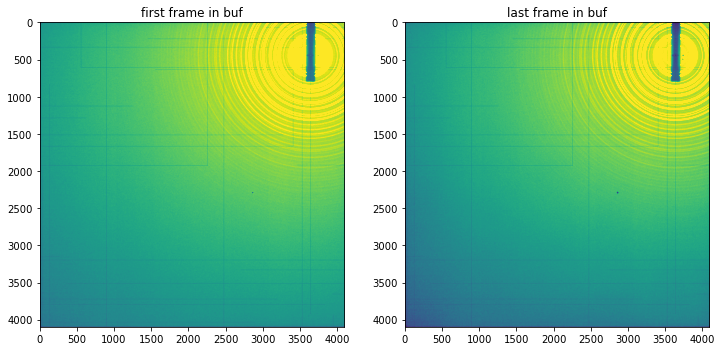

In [8]:
# plot the first and last frames
plt.figure(figsize=(12,24))
plt.subplot(1,2,1)
plt.imshow(np.sqrt(frame_dta[0,:npix].reshape(det_shape)), vmax=np.sqrt(400)) # using sqrt-scale
plt.title('first frame in buf')
plt.subplot(1,2,2)
plt.imshow(np.sqrt(frame_dta[-1,:npix].reshape(det_shape)), vmax=np.sqrt(400))
plt.title('last frame in buf');

The image data are good, but there are also some bad pixels. Let's zero them.

In [9]:
# apply mask (optional)
frame_dta[:,idx_mask] = 0

### The Integrator

Azimuthal integration is computationally equivalent to bincount or sparse matrix multiplication. In principle it takes the image pixel data and adds them into the output 'histogram' array. The [numpy documentation](https://numpy.org/doc/stable/reference/generated/numpy.bincount.html) says:

```
out = numpy.bincount(x, /, weights=None, minlength=0)
```

For Azimuthal integration the output array (`out`) must have the same length as our reciproracal space array ($Q$) or array of angles ($2\Theta$). We will set it via `minlength` argument. Integrated data will be actually `weights`. The last ingredient needed is the `x` argument. This is actually a target position of pixel data in the output integrated arrray `out`. We are using method `maxpy_erda3.ttheq_get_indexes`. This method takes detector parameters `detParams`, the integration grid array and for each image pixel it returns target indices in the output array. Some pixels may not fit into the integration grid, being e.g. out of range (or masked). `ttheq_get_indexes` returns also logical array with `True` values for pixels used in the integration.

For our case we can ignore `chi` variables which are relevant only for a *cake integration*.

We do the bincouting procedure twice. First we bincount the image data. Second we bincout the number of pixels effectively contributing to the integration. The latter we can use for normalizing the signal or calculating the error estimates of integrated data.

We define 2 functions. One for integrating the image directly. Second one is just a wrapper around `ttheq_get_indexes` to prepare auxilliary metadata structures we will need for using `numpy.bincount` directly.

In [10]:
# an integrator

import maxpy_erda3 as mp

def integ_img_np(img, mask, x, detParams, tth=0.0, N=[], M=[], tthFnc=mp.tth2Dsimple, chi=None, xtype='tth', wlen=1.):
    # interpolate (bin) image data
    #
    # get indexes to (regulary spaced) xtth, chi
    from maxpy_erda3 import ttheq_get_indexes
    idx_x, idx_chi, lidx = ttheq_get_indexes(x,tth,detParams,N,M,tthFnc,chi=chi,xtype=xtype,wlen=wlen)
    if chi is None:
        idx = idx_x
    else:
        idx = idx_x + idx_chi*len(x)
    # reduce data
    ridx  = idx[lidx]
    rimg  = img[lidx]
    rmask = mask[lidx]
    out_size = len(x) if chi is None else len(x)*len(chi)
    # integrate data
    idata = np.bincount(ridx,weights=rimg,minlength=out_size)
    ndata = np.bincount(ridx,weights=rmask,minlength=out_size)
    if chi is not None:
        idata = idata.reshape((len(chi),len(x)))
        ndata = ndata.reshape((len(chi),len(x)))
    return idata, ndata

def get_integ_metadata_2d(mask, x, detParams, tth=0.0, N=[], M=[], tthFnc=mp.tth2Dsimple, fptp=np.float32, chi=None, xtype='tth', wlen=1.):
    # returns azimuthal integration control (meta)data  
    #
    # get indexes to (regulary spaced) xtth
    from maxpy_erda3 import ttheq_get_indexes
    idx, _, lidx = ttheq_get_indexes(x,tth,detParams,N,M,tthFnc,chi=chi,xtype=xtype,wlen=wlen)
    det_shape = (det_params['n'], det_params['m'])
    # additional control (meta)data
    idx = idx.astype(np.uint16) # for compatibility with FPGA
    cor = np.ones(det_shape, dtype=fptp)
    wgt = np.ones(det_shape, dtype=fptp)
    wgt[mask>0] = 0
    # integrate data
    return idx, lidx, cor, wgt

We want the bincouting of the contributing pixels is also done in reals. This is more realistic as we may need real value corrections in many applications.

In [11]:
# force calculation in float32
weights = (det_params['mask']==0).astype(np.float32)

Let's integrate 2 frames and plot the result. You can see `ncs` is used to normalize `dta`. The integration results is a well defined pattern with very many diffraction maximas including also weak peaks that were not visible in 2D image data.

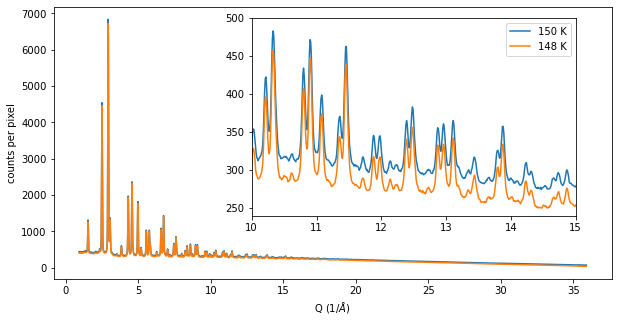

In [12]:
# integrate the first and last frame
# (no pixel splitting)

dta_first, ncs_first = integ_img_np(frame_dta[ 0,:npix].reshape(det_shape), weights, xq, det_params, xtype='q', wlen=wlen)
dta_last, ncs_last = integ_img_np(frame_dta[-1,:npix].reshape(det_shape), weights, xq, det_params, xtype='q', wlen=wlen)

lx = ncs_first>0

fig, ax1 = plt.subplots(figsize=(10,5))
plt.plot(xq[lx], dta_first[lx]/ncs_first[lx], label='%.0f K' % mtemp[ifirst])
plt.plot(xq[lx], dta_last[lx]/ncs_last[lx], label='%.0f K' % mtemp[ilast])
plt.ylabel('counts per pixel')
plt.xlabel('Q ($1/\AA$)')
ax2 = fig.add_axes([0.4, 0.3, 0.45, 0.55])
plt.plot(xq[lx], dta_first[lx]/ncs_first[lx], label='%.0f K' % mtemp[ifirst])
plt.plot(xq[lx], dta_last[lx]/ncs_last[lx], label='%.0f K' % mtemp[ilast])
plt.xlim((10,15))
plt.ylim((240,500))
plt.legend();

Integrate 32 frames and time it.

It is actually very slow as we are doing a lot of unnecessary operations including data copy.

In [13]:
# integrate all data with numpy and time it

# preallocate space for result
dta = np.zeros((frame_dta.shape[0],xq.size),dtype=np.float32)
ncs = np.zeros((frame_dta.shape[0],xq.size),dtype=np.float32)

startTime = time.time()

for iframe in np.arange(frame_dta.shape[0]):
    dta[iframe,:], ncs[iframe,:] = integ_img_np(frame_dta[iframe,:npix].reshape(det_shape), weights, xq, det_params, xtype='q', wlen=wlen)

executionTime = time.time() - startTime

print('numpy integration (n=%d), exec. time: %.3f sec' % (frame_dta.shape[0], executionTime,))
print('numpy bincout (%.3f Mpix): %.1f fps, %.1f Mpix/s' % (np.prod(frame_dta.shape[1:])/1e6, frame_dta.shape[0]/executionTime, np.prod(frame_dta.shape[1:])/1e6*frame_dta.shape[0]/executionTime,))
print(dta[0,:5], ncs[0,:5])

numpy integration (n=32), exec. time: 47.619 sec
numpy bincout (16.777 Mpix): 0.7 fps, 11.3 Mpix/s
[74008. 77058. 81615. 84231. 88309.] [168. 178. 189. 192. 200.]


In order to get a better reference for `numpy.bincount`, let's use it directly with pregenerated auxulliary structures. Note that the performance can strongly depend on the *numpy* implementation. At the time of writing this notebook the code was actually few lines in *C* (see below). There are also other implementations, e.g. in *torch*. The status there was at the time of writing very similar but the performance can be different.

```C
dans = (double *)PyArray_DATA(ans);
NPY_BEGIN_ALLOW_THREADS;
for (i = 0; i < len; i++) {
  dans[numbers[i]] += weights[i];
}
NPY_END_ALLOW_THREADS;
```

In [14]:
# integrate all data with numpy using bincount directly and time it

# preallocate space for result
dta = np.zeros((frame_dta.shape[0],xq.size),dtype=np.float32)
ncs = np.zeros((frame_dta.shape[0],xq.size),dtype=np.float32)

idx, lidx, cor, wgt = get_integ_metadata_2d(det_params['mask'], xq, det_params, xtype='q', wlen=wlen)
# reduce data and reduce dimensions
idx = idx[lidx]
wgt = wgt[lidx]
cor = cor[lidx] * wgt

startTime = time.time()

for iframe in np.arange(frame_dta.shape[0]):
    img = frame_dta[iframe]
    dta[iframe,:] = np.bincount(idx, weights=((frame_dta[iframe,:npix])[lidx.ravel()]*cor), minlength=nq)
    ncs[iframe,:] = np.bincount(idx, weights=wgt, minlength=nq)

executionTime = time.time() - startTime

print('numpy integration (n=%d), exec. time: %.3f sec' % (frame_dta.shape[0], executionTime,))
print('numpy bincout-direct (%.3f Mpix): %.1f fps, %.1f Mpix/s' % (np.prod(frame_dta.shape[1:])/1e6, frame_dta.shape[0]/executionTime, np.prod(frame_dta.shape[1:])/1e6*frame_dta.shape[0]/executionTime,))

print(dta[0,:5], ncs[0,:5])

numpy integration (n=32), exec. time: 7.568 sec
numpy bincout-direct (16.777 Mpix): 4.2 fps, 70.9 Mpix/s
[74008. 77058. 81615. 84231. 88309.] [168. 178. 189. 192. 200.]


Let's switch to FPGA now. There is another helper function to create the metadata. There is very little difference compared to one above for *numpy*.

With FPGA one must ensure the data types fit the FPGA AZINT bincout API. In this case input data are `np.uint16`, target positions `pos` are `np.uint16` as well and the output data will be `np.float32`. The masked pixels are marked by setting an edge bit position in the `pos` values, i.e. there is a special target position understood as a *sink*. An additional axilliary array `pix` is also needed. In the FPGA bincout implementation there is for each pixel index `pix`, an instruction for the target position `pos`, an (optional) pixel data correction `cor` and weights are kept in `wgt`. The latter are used e.g. for *pixel-splitting*. In the case here `pix` is just an index list of pixels, however in case of *pixel splitting* the same pixel index may occure in this array multiple times.

In [15]:
def get_integ_metadata_fpga(idx_mask, x, detParams, tth=0.0, N=[], M=[], tthFnc=mp.tth2Dsimple, fptp=np.float32, chi=None, xtype='tth', wlen=1.):
    # returns azimuthal integration control (meta)data for intel fpga
    #
    # get indexes to (regulary spaced) xtth
    from maxpy_erda3 import ttheq_get_indexes
    idx, _, lidx = ttheq_get_indexes(x,tth,detParams,N,M,tthFnc,chi=chi,xtype=xtype,wlen=wlen)
    det_shape = (det_params['n'], det_params['m'])
    npix = det_shape[0] *  det_shape[1]
    # additional control (meta)data
    pos = idx.ravel().astype(np.uint16) # for compatibility with FPGA
    pos[idx_mask] = np.bitwise_or(pos[idx_mask], np.uint16(2**15)) # mark masked pixels
    pix = np.arange(npix, dtype=np.uint32)
    cor = np.ones((npix,), dtype=fptp)
    wgt = np.ones((npix,), dtype=fptp)
    # wgt[idx_mask] = 0 # not needed
    # reduce data
    lidx = lidx.ravel()
    pos = pos[lidx]
    pix = pix[lidx]
    cor = cor[lidx]
    wgt = wgt[lidx]
    return pos, pix, cor, wgt

This time we try to load all the data into the memory. It may take a while. We will need about 45 GB of memory. If you have less try to adjust `ilast` to a smaller value.

In [16]:
# load all frames into memory (~ 45 GB)

# memory buffer is 64 bytes aligned and its length for each frame is a multuply of 4096 (for FPGA later)
from utils_intel import np_aligned_empty

ifirst = 0
ilast = mtemp.size-1
nbatch = 256

sz = ((det_shape[0]*det_shape[1] + 4095)//4096) * 4096
buf = np_aligned_empty((((ilast-ifirst+nbatch)//nbatch)*nbatch,sz,), np.uint16, 64); buf[()] = 0
frame_dta = buf[:(ilast-ifirst+1),:npix]

with h5py.File(filename,'r') as h5f:
    frame_dta[:,:] = h5f['/entry/instrument/detector/data'][ifirst:(ilast+1)].reshape(ilast-ifirst+1,-1)

print('hdf5 data are in preallocated buffer:', np.shares_memory(buf, frame_dta))

hdf5 data are in preallocated buffer: True


### Integration on FPGA

We create a `bincount_intel` object first for the integration on FPGA. Then we set the metadata needed for the processing. Finally we run the integration in batches of 256 frames. 32 frames are processed simultaneously during each single run of FPGA bincouting on A10. Supplying multiple of 32 frames will allow to pipeline the data processing and overlap processing steps as host-to-device data transfer, data transposition and bincouting itself. The whole OpenCL mechanism is encapsulated in the `bincount_intel` class except an OpenCL Event object returned by `bincount_intel.enqueue` method. This could allow even further OpenCL-like pipeling but it is actually not used here.

In [17]:
# use bincount_intel directly

# get azint control (meta)data
pos, pix, cor, wgt = get_integ_metadata_fpga(idx_mask, xq, det_params, xtype='q', wlen=wlen)

# fpga bincount
from bincount_intel import bincount_intel
# connect to device
bincount_dev = bincount_intel(board_name=str(board_name))
# set parameters
bincount_dev.set_params(nbins=nq, ndta=buf.shape[1], pix=pix, pos=pos, wgt=wgt, cor=cor, nframes=nbatch, dta = None)
# preallocate space for result
dta = np_aligned_empty((buf.shape[0]*nq,), np.float32, 64)
ncs = np_aligned_empty((buf.shape[0]*nq,), np.float32, 64)

startTime = time.time()

# integrate
for irun in np.arange(((frame_dta.shape[0]+nbatch-1)//nbatch)):
    i0 = irun * nbatch
    i1 = (irun+1) * nbatch
    ib0 = i0 * nq
    ib1 = i1 * nq
    bincount_dev.enqueue(dta[ib0:ib1], ncs[ib0:ib1], buf[i0:i1,:].ravel(), nframes=nbatch, is_blocking=True)

executionTime = time.time() - startTime

print('fpga integration (n=%d), exec. time: %.3f sec' % (frame_dta.shape[0], executionTime,))
print('fpga bincout-intel (%.3f Mpix): %.1f fps, %.1f Mpix/s' % (np.prod(frame_dta.shape[1:])/1e6, frame_dta.shape[0]/executionTime, np.prod(frame_dta.shape[1:])/1e6*frame_dta.shape[0]/executionTime,))

print(ncs[:32*nq].reshape(nq,32)[:5,0])

# reshape and reduce output data
dta = np.swapaxes(dta.reshape(buf.shape[0]//32,nq,32), 1, 2).reshape(buf.shape[0],nq)[:frame_dta.shape[0],:]
ncs = np.swapaxes(ncs.reshape(buf.shape[0]//32,nq,32), 1, 2).reshape(buf.shape[0],nq)[:frame_dta.shape[0],:]

# disconnect from device
bincount_dev = None

[azint-cl] OpenCL will use AOCX binary image: ./build/pac_a10/bincount2_intel.aocx
fpga integration (n=734), exec. time: 7.605 sec
fpga bincout-intel (16.777 Mpix): 96.5 fps, 1619.3 Mpix/s
[168. 178. 189. 192. 200.]


One can be currious what is the frequency of the FPGA design we are using. There is a helper function `utils_intel.cl_bitstream_info`. However we must mine the .aocx file path first.

In [18]:
from utils_intel import cl_bitstream_info

bitstream_file = os.path.join('./build', board_name, 'bincount2_intel.aocx')

if not os.path.isfile(bitstream_file):
    bitstream_file = os.path.join('./../build', board_name, 'bincount2_intel.aocx')
    if not os.path.isfile(bitstream_file):
        bitstream_file = None

if bitstream_file is not None:
    print('OpenCL bitstream info:', bitstream_file)
    print(cl_bitstream_info(bitstream_file))

OpenCL bitstream info: ./build/pac_a10/bincount2_intel.aocx
{'freq': 181.0}


## Visualisation and interpretation

We have hundrets of similar patterna as above. The features in them are very similar so it may help to zoom in and focuse only on a part of data. There are also some empty frames with only background noise. We can detect them with lower intensity in a selected region. Frames were taken at different time points and at different temperatures. We may prefere time or temperature as a second axis. So here we

- select range of data
- filter empty and weaker data out
- plot agains time
- use a contour plot for visualisation

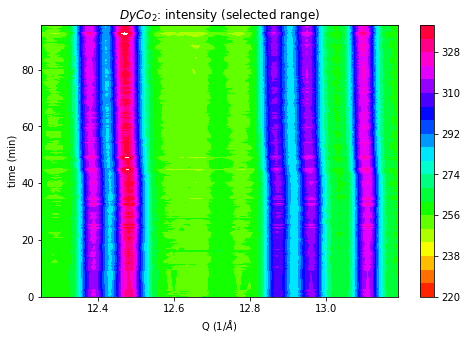

In [19]:
# selection
lidx = np.logical_and(xq>=12.25,xq<=13.2)
# some frames contain only very weak signal
lidy = np.mean(dta[:,490:510],axis=1)>4.5e5

tm = (mtime - mtime[0])/60.

# normalization/equalization
ndta = dta[lidy,:][:,lidx]/exp_time[lidy,np.newaxis]
ndta = dta[lidy,:][:,lidx]/(ncs[lidy,:][:,lidx])
deq = np.sum(ndta,axis=1) 
deq /= np.mean(deq)
ndta /= deq[:,np.newaxis]

fig = plt.figure(figsize=(8,5))
LS = np.linspace(0.6e6,1.1e6,21) # levels
LS = np.linspace(220,340,21) # levels
plt.contourf(xq[lidx],tm[lidy],ndta,levels=LS,cmap=plt.cm.hsv)
plt.xlabel('Q ($1/\AA$)')
plt.ylabel('time (min)')
plt.title('$DyCo_2$: intensity (selected range)')
plt.colorbar();

We actually see several diffraction lines. They are *bended* at certain time point, approximatelly 45 mins after starting the measurement.

We are going to investigate the *bending* effect more. We will soom to another diffractin line at $Q\approx 7.0 ~1/Å$. This is actually an (800) reflection of cubic $DyCo_2$ phase. We analyse data in this area in a more detail. We use few edge points to guess a linear background for each row of data and after subtracting background we can calculate the mean value of $\langle x \rangle$ weighted by the intensity distribution. This can be used as a simple gues of the peak position.

The position of $(800)$ reflection can be then plotted against temperature.

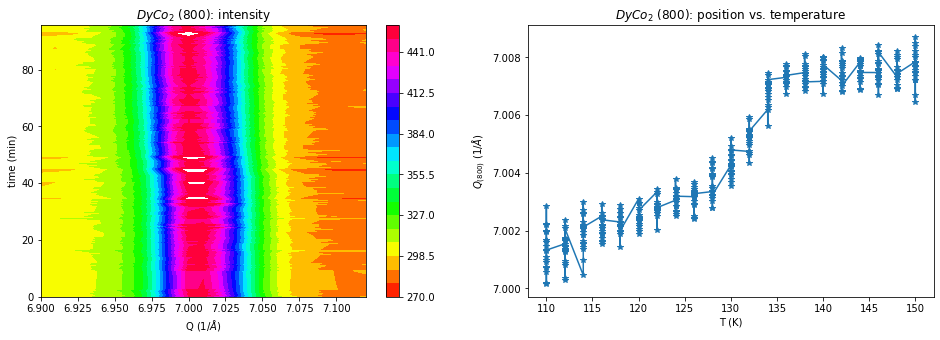

In [20]:
# selection
lidx = np.logical_and(xq>=6.9,xq<=7.12)
# some frames contain only very weak signal
lidy = np.mean(dta[:,490:510],axis=1)>4.5e5

tm = (mtime - mtime[0])/60.

# normalization & equalization
ndta = dta[lidy,:][:,lidx]/exp_time[lidy,np.newaxis]
ndta = dta[lidy,:][:,lidx]/(ncs[lidy,:][:,lidx])
deq = np.sum(ndta,axis=1) 
deq /= np.mean(deq)
ndta /= deq[:,np.newaxis]

fig = plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
LS = np.linspace(0.6e6,1.1e6,21) # levels
LS = np.linspace(270,460,21) # levels
plt.contourf(xq[lidx],tm[lidy],ndta,levels=LS,cmap=plt.cm.hsv)
plt.xlabel('Q ($1/\AA$)')
plt.ylabel('time (min)')
plt.title('$DyCo_2$ (800): intensity')
plt.colorbar();

def peak_position_simple(x,y):
    # edge points
    y0 = np.mean(y[:,0:3], axis=1)
    y1 = np.mean(y[:,-3:], axis=1)
    ny = y.shape[1]
    # subtract background
    f = y - y0[:,np.newaxis] - (y1-y0)[:,np.newaxis]/(ny-2)*(np.arange(ny)[np.newaxis,:]-1)
    # calculate <x>
    pos = np.sum(x[np.newaxis,:]*f,axis=1)/np.sum(f,axis=1)
    return pos

plt.subplot(1,2,2)
pos = peak_position_simple(xq[lidx],ndta)
plt.plot(mtemp[lidy], pos,'*-');
plt.xlabel('T (K)')
plt.ylabel('$Q_{(800)}$ ($1/\AA$)')
plt.title('$DyCo_2$ (800): position vs. temperature');

It can be observed that the peak position is increasing with increasing position and this trend is broken at $\approx 135 K$ indicating a phase transition.

## Conclusions

In this notebook it was demonstrated that
- azimuthal integration for powder diffraction data can be done with *bincount*
- *bincount* procedure can be evaluated effectively at FPGA
  - mainly metadata describing the geometry of the experiment are needed
  - the procedure can effectively orchestrated from Python
- FPGA based data crunching can be done with Jupyter notebooks in Cloud-like environement
- notebooks can be executed in particular on DeviceCloud with help of *papermill*

```bash
papermill examples/DyCo2.ipynb DyCo2-result.ipynb -k bincount-jupdemo -p PYOPENCL_CTX 0 -p board_name pac_a10
```